## Pairs Trading

This notebook contains sample code on testing out a pairs strategy using cointegration analysis

### Cointegration

Cointegration anaysis is a technique that is widely used. It can be used to find trading strategies based on the property of mean reversion. Cointegration analysis aims to find a grouping of time series (in this case, closing prices of stocks) that behaves as a stationary, or mean reverting process. When this process is below the mean, we go long. When it's above the mean, we go short the basket.

For financial data, it can be shown that returns are stationary but prices are not (see my R statistics code samples for this). However, we can find linear combination of price processes so that that such combination is stationary. The vector of coefficients we solve for is known as a cointegrating vector.

We will consider all of 2022, which as we know had significant turbulence, which should help our results look not-so-ideal.

In [4]:
import numpy as np
import pandas as pd

# We will uuse statsmodels library which can check for cointegration between 2 series
# coint uses the augmented Engle-Granger two step test
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

import yfinance as yf
import seaborn
import matplotlib.pyplot as plt

In [5]:
#Some popular stocks
symbol_list = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOG', 'TSLA', 'QCOM', 'JPM', 'GS']

data = yf.download(
    symbol_list, 
    start='2022-01-01', 
    end='2023-01-01'
)['Adj Close']

[*********************100%***********************]  9 of 9 completed


In [6]:


##Pairwise cointegration analysis
## O(n^2) algorithm
#TODO: Apply multicointegration, e.g. Phillips-Ouliaris cointegration test
#Can be 0.10 to be more permissive, or 0.025, 0.01 to be more restrictive

def find_cointegrated_pairs(data, alpha_critical = 0.05):
    rows, cols = data.shape
    score_matrix = np.zeros(shape = (cols, cols))
    pvalue_matrix = np.ones(shape = (cols, cols))

    #Note that this returns in alphabetical order. keys[0] is AAPL. symbol_list[0] is META. The yfinance package returns in alphabetical order, openbb will return in the order you give it
    #keep it consistent!
    keys = data.keys()
    pairs = []

    for i in range(cols):
        for j in range(i+1, cols):
            #Extract the two time series
            S1 = data[keys[i]]
            S2 = data[keys[j]]

            #See function spec. result is a tuple of the t-stat, the p-value, and the critical values for the test statistic at 1/5/10 levels
            #TODO: Can improve to use result[2] and a vecotrized check instead of a manual check with alpha_critical
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i,j] = score
            pvalue_matrix[i,j] = pvalue

            if pvalue < alpha_critical:
                pairs.append((keys[i], keys[j]))
        
    return score_matrix, pvalue_matrix, pairs

alpha_critical = 0.05
scores, pvalues, pairs = find_cointegrated_pairs(data, alpha_critical = alpha_critical)

Now that we have our results, let's plot them to visualize it.

We can use a heatmap from seaborn. What we are doing is plotting the pvalues matrix. We are applying a color map to it to visualize the difference in pvalues. In this example, we choose red as the highest values and green as the lowest values. To prevent the whole thing from being colored, we apply a mask to ignore all pvalues above our alpha_critical value.

[('AAPL', 'AMZN'), ('META', 'QCOM')]


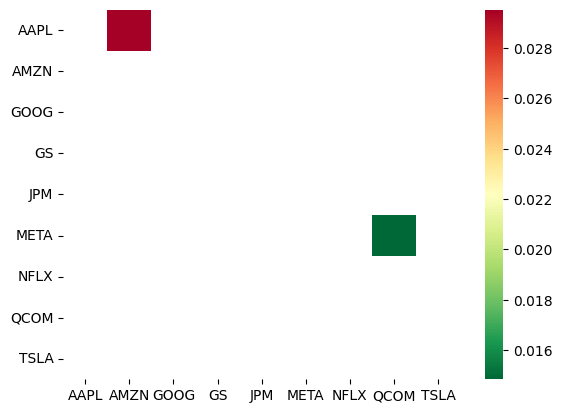

In [8]:
keys = data.keys()
seaborn.heatmap(
    pvalues, 
    xticklabels=keys, 
    yticklabels=keys, 
    cmap='RdYlGn_r', 
    mask = (pvalues >= alpha_critical)
)

print(pairs)

We see that we have two cointegrated series, AMZN/AAPL, and META/QCOM. We see this from our pairs variable and from the plot. NOTE: Remember, we used keys in our function, so we specify keys in the argument for this plot. Had we used symbol_list, we would have incorrect labels that wouldn't match pairs (try it on your end to see).

Let's look more closely at META/QCOM since it has a lower p-value.

In [9]:
# Run a linear regression
S1 = data.META
S2 = data.QCOM

#S1 = sm.add_constant(S1)
#convention: the first stock is independent, the second stock is dependent
results = sm.OLS(S2, sm.add_constant(S1)).fit()

## SEE: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   QCOM   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     779.7
Date:                Sun, 09 Jul 2023   Prob (F-statistic):           1.14e-78
Time:                        11:57:02   Log-Likelihood:                -919.76
No. Observations:                 251   AIC:                             1844.
Df Residuals:                     249   BIC:                             1851.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.5267      1.999     41.285      0.000      78.590      86.464
META           0.2956      0.011     27.924      0.000       0.275       0.316
==============================================================================
Omnibus:                       16.454   Durbin-Watson:                   0.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.018
Skew:                           0.599   Prob(JB):                     0.000202
Kurtosis:                       2.563   Cond. No.                         631.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
print(results.params)

const    82.526662
META      0.295563
dtype: float64


How do we interpret these regression results? Again, we regressed META onto QCOM. So, the results say that the price process of QCOM is equal to 0.2955*META + 82.53, assuming it is a linear relationship. In reality it is a nonlinear relationship as we know, but again, no regression is perfect. The adjusted R squared value is far from perfect, but better than average too.

Text(0.5, 0, 'Date')

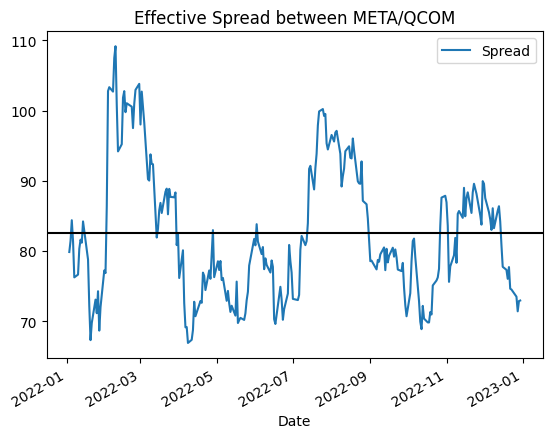

In [11]:
#S1 = S1.META
b = results.params['META']
spread = S2 - b * S1
spread.plot()
#Note that due to the properties of regression, spread.mean() is equal to the constant value from our regression results, about 82.53
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])
plt.title('Effective Spread between META/QCOM')
plt.xlabel('Date')

The spread is defined as QCOM - b*META, where b is the coefficient from the regression. Effectively, we are saying that the noise from the regression is the spread.
The problem with the analysis so far is we don't know what is a buy signal and what is a sell signal. We just know when the spread is higher than the mean, and when it's lower than the mean. We need to use a scoring methodology to generate our trade signals.

We'll stick with something simple: Z-scores. These are based on the normal distribution, and they indicate the presence of a statistical outlier. If we are above a 2 or below a -2 zscore, we'll use that as a buy.

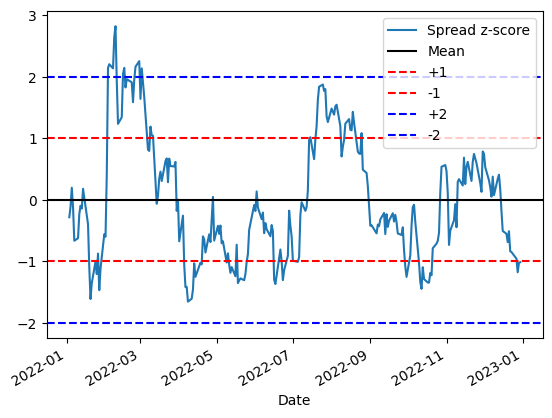

In [12]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='red', linestyle='--')
plt.axhline(2.0, color='blue', linestyle='--')
plt.axhline(-2.0, color='blue', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1', '+2', '-2']);

Unfortunately, we would not have very many buy/sell signals if we want to exceed 2. So let's lower it to 1, which is less precise, but will result in more trades taking place, which can help generate some data for us to analyze.

Now, let's construct a trades table to keep track of what our trades are, as well as the signal we observe and the position we take. Let's also take a look at the percent changes of the return series, compute the cumulative return and plot it to see whether or not this strategy is profitable.


In [13]:
trades = pd.concat([zscore(spread), spread], axis=1)
trades.columns = ["signal", "position"]
trades["side"] = 0.0

print(trades)

              signal   position  side
Date                                 
2022-01-03 -0.282581  79.857828   0.0
2022-01-04 -0.115326  81.437463   0.0
2022-01-05  0.196791  84.385252   0.0
2022-01-06 -0.118908  81.403637   0.0
2022-01-07 -0.664704  76.248861   0.0
...              ...        ...   ...
2022-12-23 -0.847866  74.518985   0.0
2022-12-27 -0.955792  73.499680   0.0
2022-12-28 -1.176599  71.414271   0.0
2022-12-29 -1.021854  72.875758   0.0
2022-12-30 -1.013905  72.950832   0.0

[251 rows x 3 columns]


In [14]:
#This is NOT FIX Tag side. This is used for computation of our PNL
#If the spread is low, go long (buy), side = 1. If it's high, go short (side is -1). Otherwise do nothing.
trades.loc[trades.signal <= -1, "side"] = 1
trades.loc[trades.signal >= 1, "side"] = -1

print(trades[trades["side"] == 1])

              signal   position  side
Date                                 
2022-01-19 -1.095200  72.183044   1.0
2022-01-20 -1.611132  67.310320   1.0
2022-01-21 -1.352712  69.750970   1.0
2022-01-24 -1.000243  73.079865   1.0
2022-01-25 -1.205005  71.145988   1.0
2022-01-27 -1.467363  68.668151   1.0
2022-01-28 -1.114690  71.998967   1.0
2022-04-05 -1.050236  72.607703   1.0
2022-04-06 -1.417858  69.135702   1.0
2022-04-07 -1.413066  69.180954   1.0
2022-04-08 -1.653573  66.909490   1.0
2022-04-11 -1.606503  67.354040   1.0
2022-04-12 -1.458905  68.748031   1.0
2022-04-13 -1.032464  72.775548   1.0
2022-04-14 -1.250740  70.714042   1.0
2022-04-18 -1.021623  72.877943   1.0
2022-04-19 -1.048566  72.623474   1.0
2022-05-09 -1.017988  72.912270   1.0
2022-05-11 -1.053368  72.578121   1.0
2022-05-12 -1.186055  71.324961   1.0
2022-05-13 -1.092379  72.209686   1.0
2022-05-16 -1.241605  70.800317   1.0
2022-05-18 -1.352954  69.748682   1.0
2022-05-19 -1.310893  70.145925   1.0
2022-05-20 -

<Axes: xlabel='Date'>

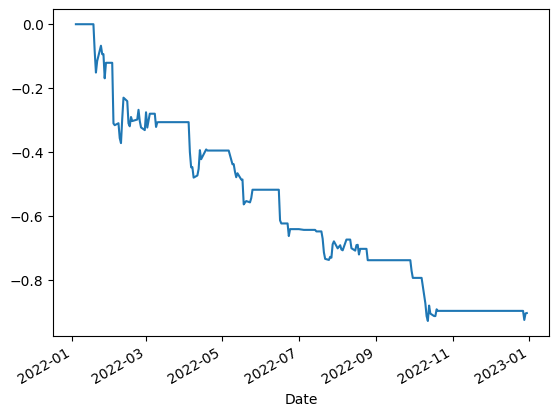

In [15]:
returns = trades.position.pct_change() * trades.side
theoretical = 100 *(1+returns)
returns.cumsum().plot()
#theoretical.plot()

What we observe is that this strategy is consistently losing money. Why is that?

Well, there are a lot of reasons that could be at play, but there is one glaring error that should have been obvious for anyone that has ever backtested before. We never used our rolling regression! We simply took all of the data from the time period (2022 calendar year), used that to compute a regression, and then computed trading signals for individaul dates in 2022 based on all of 2022's data.

**This is not okay.**

We cannot use future data to inform trading decisions for the current. What we need to do is use a portion of our data, say the first 90 trading days of stock price data for the pair to inform our decision on the 91st day. Then we use the 90 days between trading day #2 and 91 (inclusive) to inform our decisions on 92. And so on and so forth.

Let us now implement this with a rolling regression with a window = 90, for 90 trading days.

Text(0.5, 1.0, 'Constant value from regression')

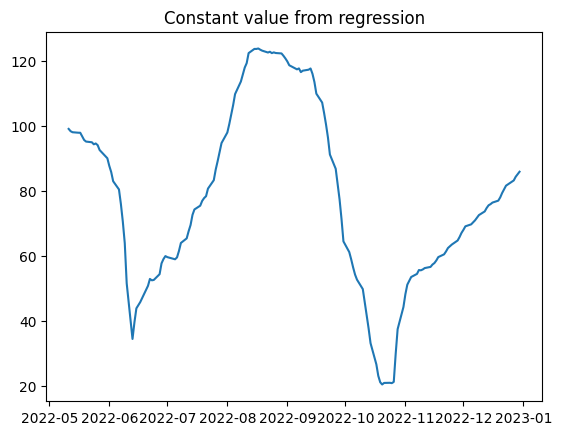

In [16]:
# https://www.statsmodels.org/stable/generated/statsmodels.regression.rolling.RollingRegressionResults.html#statsmodels.regression.rolling.RollingRegressionResults
results2 = RollingOLS(S2, sm.add_constant(S1), window = 90).fit()
first_idx = results2.params['const'].first_valid_index()

plt.plot(results2.params['const'])
plt.title('Constant value from regression')

Text(0.5, 1.0, 'Coefficient from regression')

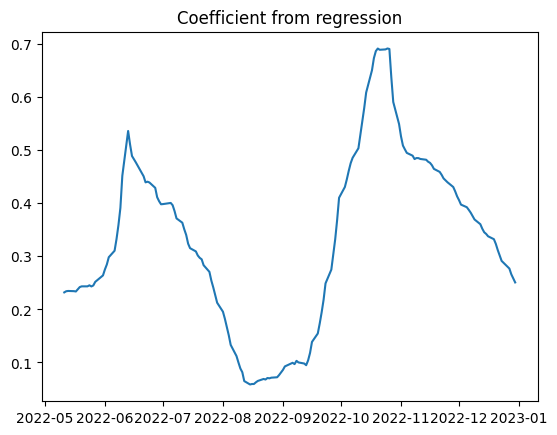

In [21]:
plt.plot(results2.params['META'])
plt.title('Coefficient from regression')

What we see from the two plots is that over time the coefficients change considerably, meaning the ratio of stocks we buy/sell should also vary considerably.

In [22]:
rolling_spread = data.QCOM - results2.params['META']*data.META
rolling_coeff = results2.params['META']

# Get rid of the burn in period
rolling_spread = rolling_spread[first_idx:]
rolling_coeff = rolling_coeff[first_idx:]

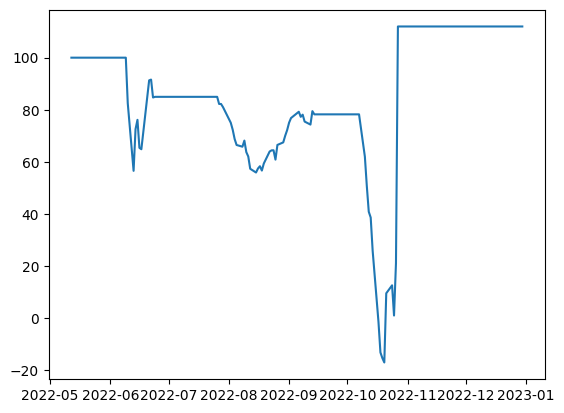

In [33]:
rtrades = pd.concat([zscore(rolling_spread), rolling_spread], axis=1)
rtrades.columns = ["signal", "position"]
rtrades["side"] = 0.0
rtrades.loc[rtrades.signal <= -1, "side"] = 1
rtrades.loc[rtrades.signal >= 1, "side"] = -1

#rreturns = rtrades.position.pct_change() * rtrades.side
rreturns = rtrades.position.pct_change(1) * rtrades.side

#rreturns.cumsum().plot()

rprices = (1 + rreturns.cumsum()) * 100

plt.plot(rprices)

What we see is that had we invested $100, we'd be zeroed out before this has a chance to recover. This is still a bad strategy.

How could we possibly improve this? There is a chance that a simple linear model is an underfit. As we saw, even with a rolling window applied there is a lot of variability with the parameters computed from the regression. We could try some machine learning models instead.

We could also revisit our approach to finding pairs. The Phillips-Ouliaris test is one example. It regresses one integrated series on others and applies the Phillips-Perron unit root test to the residuals. The null hypothesis is that the series are not cointegrated, so a small p-value implies the series are cointegrated. 

Another tool we can use is Hurst Exponents. These measure the long-term memory of a time series. The motivation is that the variance of a a time series with a particular lag, say $\tau$ should be $\tau$ if the series is a geometric brownian motion (random walk). However, if we assume the variance to be $\tau^2H$, where H is an arbitrary value, it can be shown that for $H < 0.5$ we have a mean-reverting process. For $H > 0.5$ we will have an explosive, or trending process. $H$ is referred to as the hurst exponent.

Another big improvement is to simplify our rebalance scheme. This method of multiplying the position by the side variable automatically assumes we are always rebalancing to a buy or a sell. Such active trading could be good, but we have to keep in mind we would have transaction costs pile up, which were ignored in this toy example.


As an aside, I'd like to explain why we are using simple returns here. The simple answer is we want to recover the price process in a way that makes sense.

In this screenshot I take the adjusted closing prices of META in the left hand column. First I compute log returns and then recover the price process for $100 of notional. Then I compare it to simple returns. We see that the processes will deviate considerably. However, the simple return process let's us easily recover the notional value of our investment, which is confirmed by computing the ratio of the actual META prices (price at current time divided by price on day 1). This spreadsheet has been added to the repo.

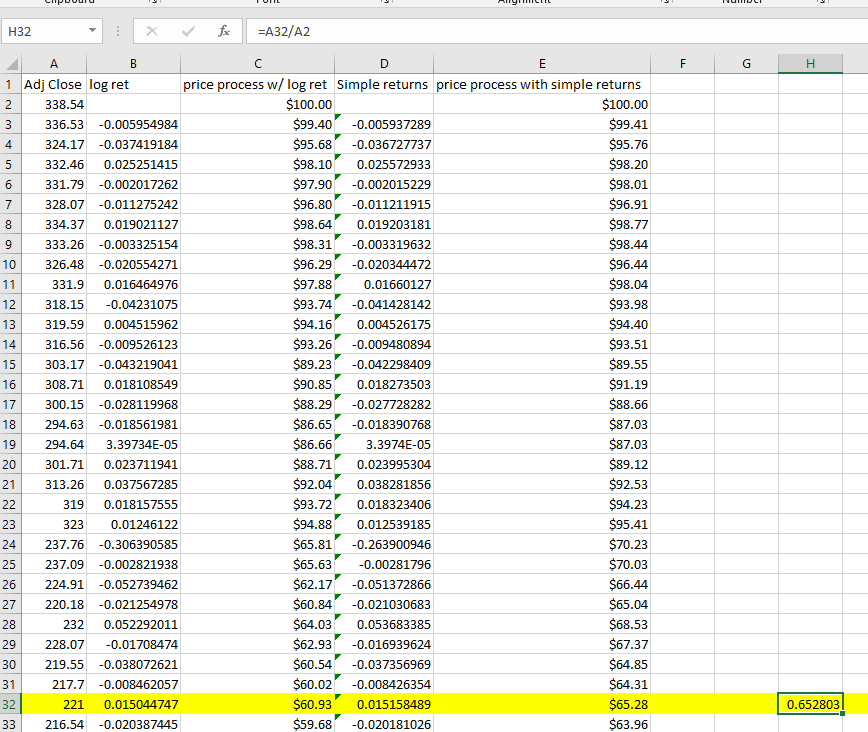

### Conclusion

Overall, this was a fun exercise, however, there's a lot of improvements to be made. Significant refinement would need to be done in order to actually use such a strategy.